The purpose of this notebook is to evaluate if sampling only outside of obstacles yields a better solution more data efficiently. If successful, this has positive implications for limited horizon and cluttered environments.

In [1]:
!pip install dill
!pip install opencv-python
import dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.1 MB/s eta 0:00:00


In [2]:
import jax
import numpy as onp
import jax.numpy as np
from jax import random, grad, hessian, vmap, jit, config, ops
from jax.nn import sigmoid, relu, elu, softplus, swish, tanh
from jax.example_libraries import optimizers
import jaxlib

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

import cvxpy as cp
import scipy.sparse as sp

import os
import cv2

%matplotlib inline

In [3]:
#For GPU use, check the device before importing anything from torch
jaxlib_version = jaxlib.__version__
print("jaxlib version:", jaxlib_version)
jax_version = jax.__version__
print("JAX version:", jax_version)
print(jax.local_devices())

jaxlib version: 0.4.33
JAX version: 0.4.33
[CpuDevice(id=0)]


In [4]:
from torch.utils import data
print(jax.local_devices())

[CpuDevice(id=0)]


In [5]:
# Build custom activation
def custom_softplus(x, beta=1):
    return (1 / beta) * np.log1p(np.exp(beta * x)) #This beta can't be large, causes gradient overflow during training
def custom_tanh(x, beta=1):
    return np.tanh(beta * x)

softplus = partial(custom_softplus, beta=1)
tanh = partial(custom_tanh, beta=1)

In [6]:
#Model
input_dim = 2
output_dim = 1
layers = [2, 50, 50, 1]
activation = tanh #tanh, elu, custom
output_activation = softplus # softplus, swish, custom
cfunc_type = 'safety' #'safety', 'sdf'

#Cfunc
num_rect = 3
num_circ = 0
beta = 8
sharpness = 8

x_min, x_max, y_min, y_max = 0, 10, -5, 5
r_min, r_max, s_min, s_max = .5, 2, .5, 2
u = 1 #u_min, u_max = -1, 1

#training
P_train = 10000 # number of random samples for training
epsilon_train = 0 #c>epsiolon at samples
epsilon_val = 0

batch_size = 10000
epochs = 30000

ilr = 1e-3
flr = 1e-4
total_steps = epochs * (P_train / batch_size)

decay_rate = .8
if decay_rate < 1 and flr < ilr:
    decay_steps = int(total_steps * np.log(decay_rate) / np.log(flr/ilr))
else:
    decay_steps = 1e9


#Residuals
gamma = .1
lamb_0 = 1
lamb_1 = 0.1
p = 2

#Validation
P_val = 100000

In [7]:
#[theta, s1, s2, x_c, y_c]
def generate_rectangles(key, numrect):
    key_thetas, key_side1s, key_side2s, key_center1s, key_center2s = random.split(key, 5)
    thetas = random.uniform(key_thetas, shape=(numrect,), minval=0, maxval=2*np.pi)
    s1 = random.uniform(key_side1s, shape=(numrect,), minval=s_min, maxval=s_max)
    s2 = random.uniform(key_side2s, shape=(numrect,), minval=s_min, maxval=s_max)
    x_c = random.uniform(key_center1s, shape=(numrect,), minval=x_min, maxval=x_max)
    y_c = random.uniform(key_center2s, shape=(numrect,), minval=y_min, maxval=y_max)
    rectangles = np.column_stack((thetas, s1, s2, x_c, y_c))

    return rectangles

#[r, x_c, y_c]
def generate_circles(key, numcirc):
    key_radii, key_center1s, key_center2s = random.split(key, 3)
    radii = random.uniform(key_radii, shape=(numcirc,), minval=r_min, maxval=r_max)
    x_c = random.uniform(key_center1s, shape=(numcirc,), minval=x_min, maxval=x_max)
    y_c = random.uniform(key_center2s, shape=(numcirc,), minval=y_min, maxval=y_max)
    circles = np.column_stack((radii, x_c, y_c))

    return circles

# Set the seed for reproducibility
key = random.PRNGKey(20)
# Generate shapes

rectangles = [[0, 1, .5, 2, 0], [0, 1, 1, 3, 2], [np.pi/3, 1.5, .5, 6, 0]]
circles = generate_circles(key, num_circ)

print(rectangles)
print(circles)

[[0, 1, 0.5, 2, 0], [0, 1, 1, 3, 2], [1.0471975511965976, 1.5, 0.5, 6, 0]]
[]


In [8]:
#c function
@jit
def rectangular_safety(x, y, s1, s2):
    # x, y are assumed inverted

    # Calculate distances from the edges of the rectangle
    dx_edge = abs(x) - s1 / 2
    dy_edge = abs(y) - s2 / 2

    # Calculate the minimum distance from the boundary
    max_out = np.maximum(dx_edge, dy_edge)

    return  max_out

@jit
def smooth_rectangular_safety(x, y, s1, s2, sharpness = sharpness):
    # x, y are assumed inverted

    # Calculate distances from the edges of the rectangle
    dx_edge = (np.log(np.exp(sharpness * x) + np.exp(sharpness * -x)) - np.log(2)) / sharpness - s1 / 2
    dy_edge = (np.log(np.exp(sharpness * y) + np.exp(sharpness * -y)) - np.log(2)) / sharpness - s2 / 2

    # Calculate the minimum distance from the boundary
    max_out = (np.log(np.exp(sharpness * dx_edge) + np.exp(sharpness * dy_edge)) - np.log(2)) / sharpness #Overuse of sharpness

    return  max_out

@jit
def cfunc(px, py, rectangles, circles):
    violations = []
    violations.append((px - x_min) * (x_max - px))
    violations.append((py - y_min) * (y_max - py))

    for rect in rectangles:

        theta, s1, s2, x_c, y_c = rect


        x_centered = px - x_c
        y_centered = py - y_c


        x_inv = x_centered * np.cos(-theta) - y_centered * np.sin(-theta)
        y_inv = x_centered * np.sin(-theta) + y_centered * np.cos(-theta)

        violations.append(rectangular_safety(x_inv, y_inv, s1, s2))

    for circ in circles:
         r, x_c, y_c, = circ

         violations.append((px - x_c)**2 + (py - y_c)**2 - r**2)

    return np.sign(np.min(np.array(violations)))


@jit
def smooth_cfunc(px, py, rectangles, circles, beta=beta):
    sum_exp = np.exp(-beta * np.tanh(px - x_min) * np.tanh(x_max - px)) + np.exp(-beta * np.tanh(py - y_min) * np.tanh(y_max - py))

    for rect in rectangles:

        theta, s1, s2, x_c, y_c = rect

        x_centered = px - x_c
        y_centered = py - y_c

        x_inv = x_centered * np.cos(-theta) - y_centered * np.sin(-theta)
        y_inv = x_centered * np.sin(-theta) + y_centered * np.cos(-theta)

        sum_exp += np.exp(-beta * np.tanh(smooth_rectangular_safety(x_inv, y_inv, s1, s2)))

    for circ in circles:
         r, x_c, y_c, = circ

         sum_exp += np.exp(-beta * np.tanh((px - x_c)**2 + (py - y_c)**2 - r**2))

    log_sum_exp = -np.log(sum_exp) / beta

    return log_sum_exp

In [9]:
def visualize_cfunc(p=200, rectangles = rectangles, circles = circles):
    x_values = np.linspace(x_min - 1, x_max + 1, 200)
    y_values = np.linspace(y_min - 1, y_max + 1, 200)
    X, Y = np.meshgrid(x_values, y_values)
    X_flat = X.ravel()
    Y_flat = Y.ravel()

    # Compute Z values over the grid using vmap
    Z_flat = vmap(cfunc, (0, 0, None, None))(X_flat, Y_flat, rectangles, circles)
    Z_flat_smooth = vmap(smooth_cfunc, (0, 0, None, None))(X_flat, Y_flat, rectangles, circles)

    Z = Z_flat.reshape(X.shape)
    Z_smooth = Z_flat_smooth.reshape(X.shape)

    # Calculate the difference
    Z_difference = Z - Z_smooth

    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(24, 7))  # Adjusted for three plots

    # Plot Z
    cp1 = ax[0].contourf(X, Y, Z, levels=50, cmap='coolwarm')
    contour1 = ax[0].contour(X, Y, Z, levels=[0], colors='k', linestyles='--')
    fig.colorbar(cp1, ax=ax[0])
    ax[0].set_title('cfunc Contour Plot')
    ax[0].set_xlabel('X coordinate')
    ax[0].set_ylabel('V coordinate')

    # Plot Z_smooth
    cp2 = ax[1].contourf(X, Y, Z_smooth, levels=50, cmap='coolwarm')
    contour2 = ax[1].contour(X, Y, Z_smooth, levels=[0], colors='k', linestyles='--')
    fig.colorbar(cp2, ax=ax[1])
    ax[1].set_title('Smooth cfunc Contour Plot')
    ax[1].set_xlabel('X coordinate')
    ax[1].set_ylabel('V coordinate')

    # Plot difference
    cp3 = ax[2].contourf(X, Y, Z_difference, levels=50, cmap='coolwarm')
    contour3 = ax[2].contour(X, Y, Z_difference, levels=[0], colors='k', linestyles='--')
    fig.colorbar(cp3, ax=ax[2])
    ax[2].set_title('Difference (Z - Z_smooth)')
    ax[2].set_xlabel('X coordinate')
    ax[2].set_ylabel('V coordinate')

    plt.tight_layout()
    plt.show()

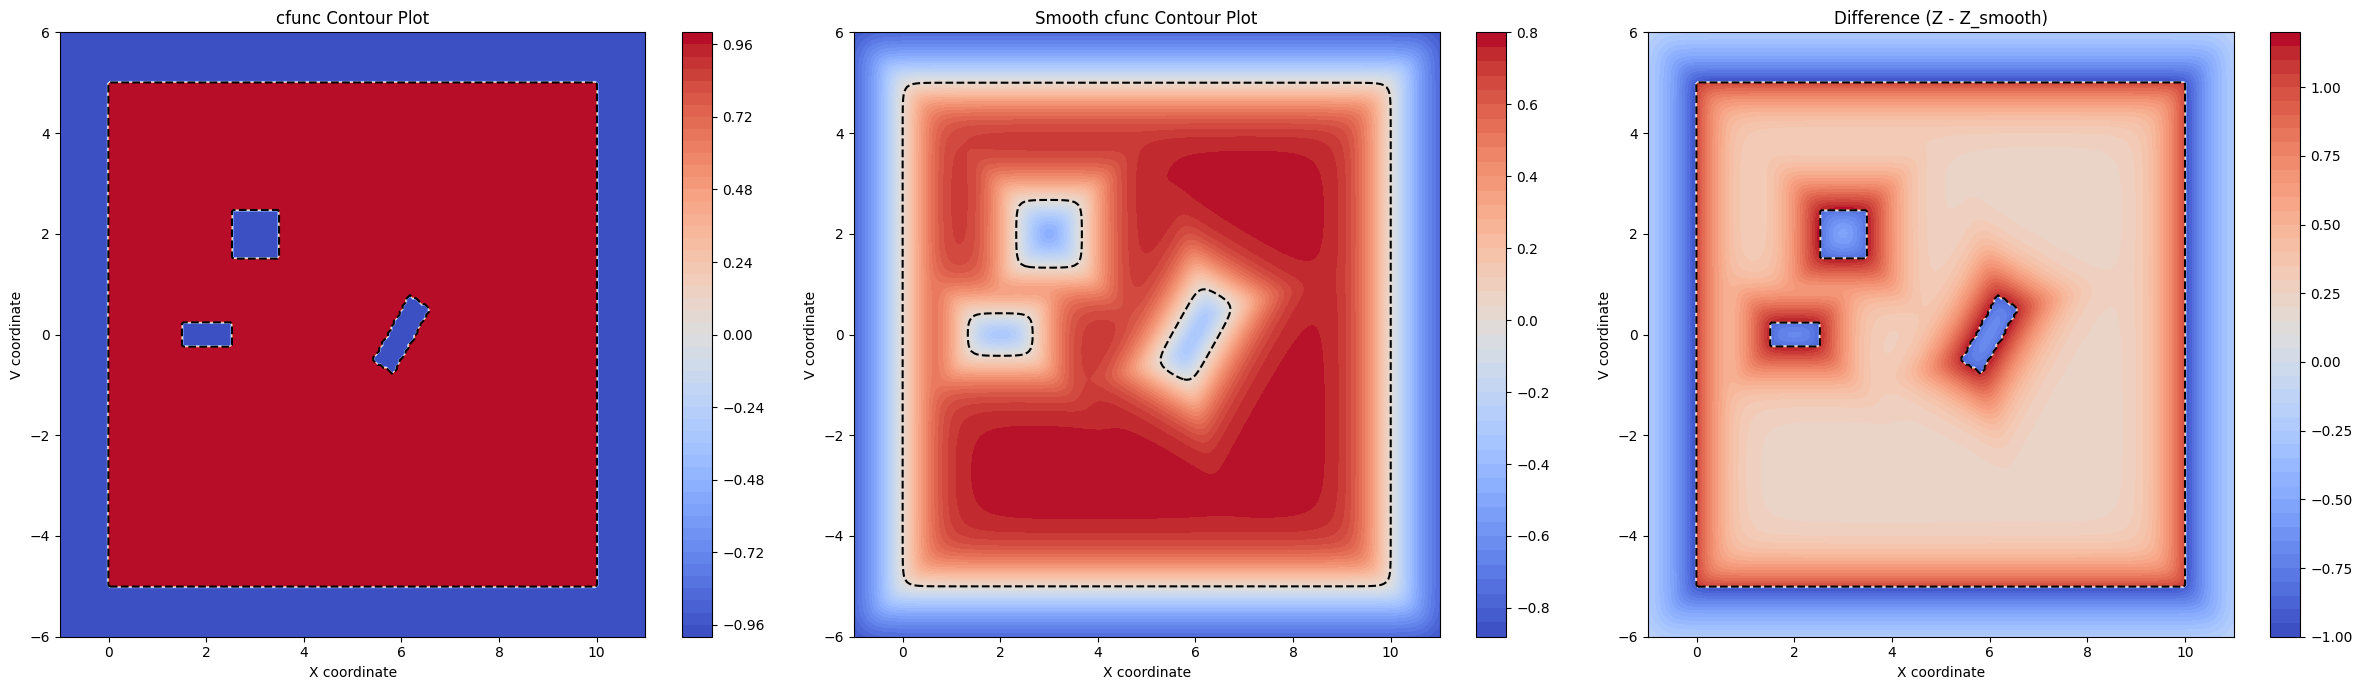

In [10]:
visualize_cfunc()

In [11]:
#softplus or tanh activtions can be used
#Batchnorm not implemented for test time. use-batchnorm=False
def MLP(layers, activation=tanh, use_batchnorm=False, init_last_zeros=False, noise_std=1e-8): #Numerical issues if initalized exactly at 0
    ''' MLP with optional BatchNorm'''
    def init(rng_key):
        def init_layer(key, d_in, d_out, init_zeros=False):
            k1, k2 = random.split(key)
            if init_zeros:
                # W = np.zeros((d_in, d_out))
                # b = np.zeros(d_out)
                W = noise_std * random.normal(k1, (d_in, d_out))
                b = noise_std * random.normal(k2, (d_out,))
            else:
                glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
                W = glorot_stddev * random.normal(k1, (d_in, d_out))
                b = np.zeros(d_out)
            if use_batchnorm:
                # Initialize batchnorm parameters
                scale = np.ones(d_out)
                offset = np.zeros(d_out)
                return W, b, scale, offset
            else:
                return W, b

        key, *keys = random.split(rng_key, len(layers))
        if init_last_zeros:
            params = list(map(init_layer, keys[:-1], layers[:-1], layers[1:], [False]*(len(layers)-1)))
            last_layer_params = init_layer(keys[-1], layers[-2], layers[-1], True)
            params.append(last_layer_params)
        else:
            params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs, is_training=True):
        for layer_params in params[:-1]:
            W, b = layer_params[:2]  # Get weights and biases
            outputs = np.dot(inputs, W) + b
            if use_batchnorm:
                # Extract batchnorm parameters
                scale, offset = layer_params[2:]
                # Compute batch normalization manually
                mean = np.mean(outputs, axis=0)
                variance = np.var(outputs, axis=0)
                normalized_outputs = (outputs - mean) / np.sqrt(variance + 1e-5)
                outputs = scale * normalized_outputs + offset
            outputs = activation(outputs)
            inputs = outputs
        W, b = params[-1][:2]  # Last layer weights and biases
        outputs = np.dot(inputs, W) + b
        return outputs

    return init, apply

In [12]:
#This functions like a dataloader
class DataGenerator(data.Dataset):
    def __init__(self, y, c, gradc, batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.y = y  # Queries
        self.c = c  # Safety function values corresponding to queries
        self.gradc = gradc

        self.N = y.shape[0]
        self.batch_size = min(batch_size, self.N)  # Ensure batch_size is smaller than N
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        y, c, gradc = self.__data_generation(subkey)
        return y, c, gradc

    def __len__(self):
        'Denotes the total number of samples'
        return self.N

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        y = self.y[idx, :]
        c = self.c[idx, :]
        gradc = self.gradc[idx, :]

        return y, c, gradc

In [13]:
#Calculate the gradient
# Gradient Helper function for c
def get_gradc(y1, y2, rectangles, circles):
    gradc_y1 = grad(smooth_cfunc, argnums=0)(y1, y2, rectangles, circles)
    gradc_y2 = grad(smooth_cfunc, argnums=1)(y1, y2, rectangles, circles)

    return np.array([gradc_y1, gradc_y2])

def sample_training_data(key, P=P_train, rectangles=rectangles, circles=circles, epsilon=epsilon_train, sample_outside=True):
    # Generate a batch of random samples
    def generate_samples(key, num_samples):
        key1, key2 = random.split(key)
        x_samples = random.uniform(key1, (num_samples,), minval=x_min - (1 - sample_outside), maxval=x_max + (1 - sample_outside))
        y_samples = random.uniform(key2, (num_samples,), minval=y_min - (1 - sample_outside), maxval=y_max + (1 - sample_outside))
        return np.column_stack((x_samples, y_samples)) #multiple samples so use column stack

    # Unified function to compute c values
    def compute_c_values(y_samples):
        c_values_smooth = vmap(smooth_cfunc, (0, 0, None, None))(y_samples[:, 0], y_samples[:, 1], rectangles, circles)
        #c_values_normal = vmap(cfunc, (0, 0, None, None))(y_samples[:, 0], y_samples[:, 1], rectangles, circles)
        #return np.where(smooth, c_values_smooth, c_values_normal)
        return c_values_smooth

    # Main sampling loop
    y_list = []
    if sample_outside:
        while len(y_list) < P:
            # Generate a batch of samples
            key, subkey = random.split(key)
            batch_size = P - len(y_list) # Adaptive batch size strategy
            y_samples = generate_samples(subkey, batch_size)

            # Compute c values for the entire batch
            c_values = compute_c_values(y_samples)

            # Create a boolean mask for valid samples
            valid_mask = c_values >= -epsilon_train
            valid_samples = y_samples[valid_mask]

            # Append valid samples to the list
            y_list.extend(valid_samples.tolist())
    else:
         y_samples = generate_samples(key, P)
         y_list.extend(y_samples.tolist())

    # Convert list to array
    y = np.array(y_list)

    # Compute values for c, gradc at sampled points
    c = vmap(smooth_cfunc, (0, 0, None, None))(y[:, 0], y[:, 1], rectangles, circles)
    gradc = vmap(get_gradc, (0, 0, None, None))(y[:, 0], y[:, 1], rectangles, circles)

    return y, c, gradc


def sample_validation_data(P=P_val, rectangles=rectangles, circles=circles, epsilon=epsilon_val, sample_outside=True):
    # Generate a uniform mesh of points
    x_vals = np.linspace(x_min - (1 - sample_outside), x_max + (1 - sample_outside), int(np.sqrt(P)))
    y_vals = np.linspace(y_min - (1 - sample_outside), y_max + (1 - sample_outside), int(np.sqrt(P)))
    mesh = np.array(np.meshgrid(x_vals, y_vals)).T.reshape(-1, 2)  # Reshape into (N, 2)

    if sample_outside:
        # Compute the smooth_cfunc values for all mesh points
        c_values = vmap(smooth_cfunc, (0, 0, None, None))(mesh[:, 0], mesh[:, 1], rectangles, circles)
        # Keep only the points where smooth_cfunc is non-negative (outside obstacles)
        valid_indices = c_values >= -epsilon_val
        mesh = mesh[valid_indices]

    # Compute values for c and gradc at the remaining mesh points
    c = vmap(smooth_cfunc, (0, 0, None, None))(mesh[:, 0], mesh[:, 1], rectangles, circles)
    gradc = vmap(get_gradc, (0, 0, None, None))(mesh[:, 0], mesh[:, 1], rectangles, circles)

    return mesh, c, gradc

In [14]:
class PI_MLP:
    def __init__(self, layers, lamb_0=lamb_0, lamb_1=lamb_1, p=p,activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True):
        # Network initialization and evaluation functions
        self.init, self.apply = MLP(layers, activation=activation, use_batchnorm=use_batchnorm, init_last_zeros=init_last_zeros)
        self.p = p
        self.lamb_0 = lamb_0
        self.lamb_1 = lamb_1
        self.output_activation = output_activation

        # Loss function

        # Initialize
        params = self.init(rng_key=random.PRNGKey(1234))

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(optimizers.exponential_decay(ilr, decay_steps=decay_steps, decay_rate=decay_rate))

        # Initialize optimizer state for both phases
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()

        self.nIter = int(P_train / batch_size * epochs)

        # Logger
        self.loss_log = []

    def update_nIter(self, epochs_new):
        self.nIter = int(P_train / batch_size * epochs_new)

    def plot_losses(self):
        # Plotting losses
        plt.figure(figsize=(12, 6))
        plt.plot(self.loss_log, label='Loss', color='blue')

        # Labels and Legends
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        # Show plot
        plt.show()

    #Plotting function for test
    def plot_predictions(self, P = 200):
        y1 = np.linspace(-1, 11, P)
        y2 = np.linspace(-6, 6, P)
        y1, y2 = np.meshgrid(y1, y2)
        y = np.hstack((y1.flatten()[:, None], y2.flatten()[:, None]))  # shape = (P**2, 2)
        # Evaluate smooth_cfunc over y


        c = vmap(smooth_cfunc, (0, 0, None, None))(y[:, 0], y[:, 1], rectangles, circles)

        # Plotting
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Adjusted for three plots

        # Plot c
        cp1 = ax[0].contourf(y1, y2, c.reshape(P, P), levels=50, cmap='coolwarm')
        contour1 = ax[0].contour(y1, y2, c.reshape(P, P), levels=[0], colors='black')
        fig.colorbar(cp1, ax=ax[0])
        ax[0].set_title('cfunc Contour Plot')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('v')

        # Generate predictions for CBF
        params = self.get_params(self.opt_state)
        outputs = vmap(self.net_diff, (None, 0, 0))(params, y[:, 0], y[:, 1])

        h = c - outputs

        # Plot CBF
        cp2 = ax[1].contourf(y1, y2, h.reshape(P, P), levels=50, cmap='coolwarm')
        contour2 = ax[1].contour(y1, y2, h.reshape(P, P), levels=[0], colors='black')
        fig.colorbar(cp2, ax=ax[1])
        ax[1].set_title('CBF')
        ax[1].set_xlabel('x')
        ax[1].set_ylabel('v')

        plt.tight_layout()
        plt.show()

    def net_diff(self, params, y1, y2):
        input_vector = np.hstack([y1, y2])
        out = np.squeeze(self.apply(params, input_vector))
        output = self.output_activation(out)

        return output

    def get_grad_delta(self, y1, y2):
        params = self.get_params(self.opt_state)
        delta_y1 = grad(self.net_diff, argnums=1)(params, y1, y2)
        delta_y2 = grad(self.net_diff, argnums=2)(params, y1, y2)

        # Return the spatial gradient components
        return np.array([delta_y1, delta_y2])

    def derivative_h(self, dc, ddelta):
        return dc  -  ddelta

    def residuals(self, params, y1, y2, c, c_y1, c_y2, gamma=gamma):
        delta = self.net_diff(params, y1, y2)
        delta_y1 = grad(self.net_diff, argnums=1)(params, y1, y2)
        delta_y2 = grad(self.net_diff, argnums=2)(params, y1, y2)
        h = c - delta

        h_y1 = self.derivative_h(c_y1, delta_y1)
        h_y2 = self.derivative_h(c_y2, delta_y2)

        res_I = np.min(np.array([delta, y2 * h_y1 + u * np.abs(h_y2) + gamma * h]))
        res_II = relu(- y2 * h_y1 - u * np.abs(h_y2) - gamma * h)

        return np.array([res_I, np.squeeze(res_II)])


    def residual(self, params, y1, y2, c, c_y1, c_y2, gamma=gamma):
        res = self.residuals(params, y1, y2, c, c_y1, c_y2)

        return  self.lamb_0 * res[0]**p + self.lamb_1 * res[1]**p

    def loss(self, params, batch):
        # Fetch data
        y, c, gradc = batch
        c_squeeze = np.squeeze(c)
        # Compute forward pass
        pred = vmap(self.residual, (None, 0, 0, 0, 0, 0))(params, y[:, 0], y[:, 1], c_squeeze, gradc[:, 0], gradc[:, 1])
        # Compute loss
        loss = np.mean(pred)
        return loss

    # Define a compiled update step for phase
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    def train(self, train_dataset):
        data = iter(train_dataset)

        pbar = trange(self.nIter)
        for it in pbar:
            batch = next(data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute and store losses
                loss_value = self.loss(params, batch)
                self.loss_log.append(loss_value)
                # Print losses
                pbar.set_postfix({'Train Loss': loss_value})

In [15]:
# validation is always in the case where samples are outside the smoothed obstacles
def validation(model, y_val, c_val, gradc_val, gamma=gamma):
        ndata = y_val.shape[0]
        params = model.get_params(model.opt_state)

        res_both = vmap(model.residuals, (None, 0, 0, 0, 0, 0))(params, y_val[:,0], y_val[:,1], c_val, gradc_val[:,0], gradc_val[:,1])

        res_I = res_both[:,0]
        res_II = res_both[:,1]
        abs_res_I = np.abs(res_I)

        delta_val = vmap(model.net_diff, (None, 0, 0))(params, y_val[:,0], y_val[:,1])
        h_val = c_val - delta_val

        # Compute relative volume
        rel_vol = np.mean(h_val >= 0)

        # Compute other metrics
        avg_abs_res_I = np.mean(abs_res_I)
        max_abs_res_I = np.max(abs_res_I)
        std_abs_res_I = np.std(abs_res_I)
        avg_safety = np.mean(res_II)

        # Print the calculated values
        print(f"Average of abs_res_I: {avg_abs_res_I}")
        print(f"Maximum of abs_res_I: {max_abs_res_I}")
        print(f"Standard deviation of abs_res_I: {std_abs_res_I}")
        print(f"Average of safety: {avg_safety}")
        print(f"Relative volume: {rel_vol}")

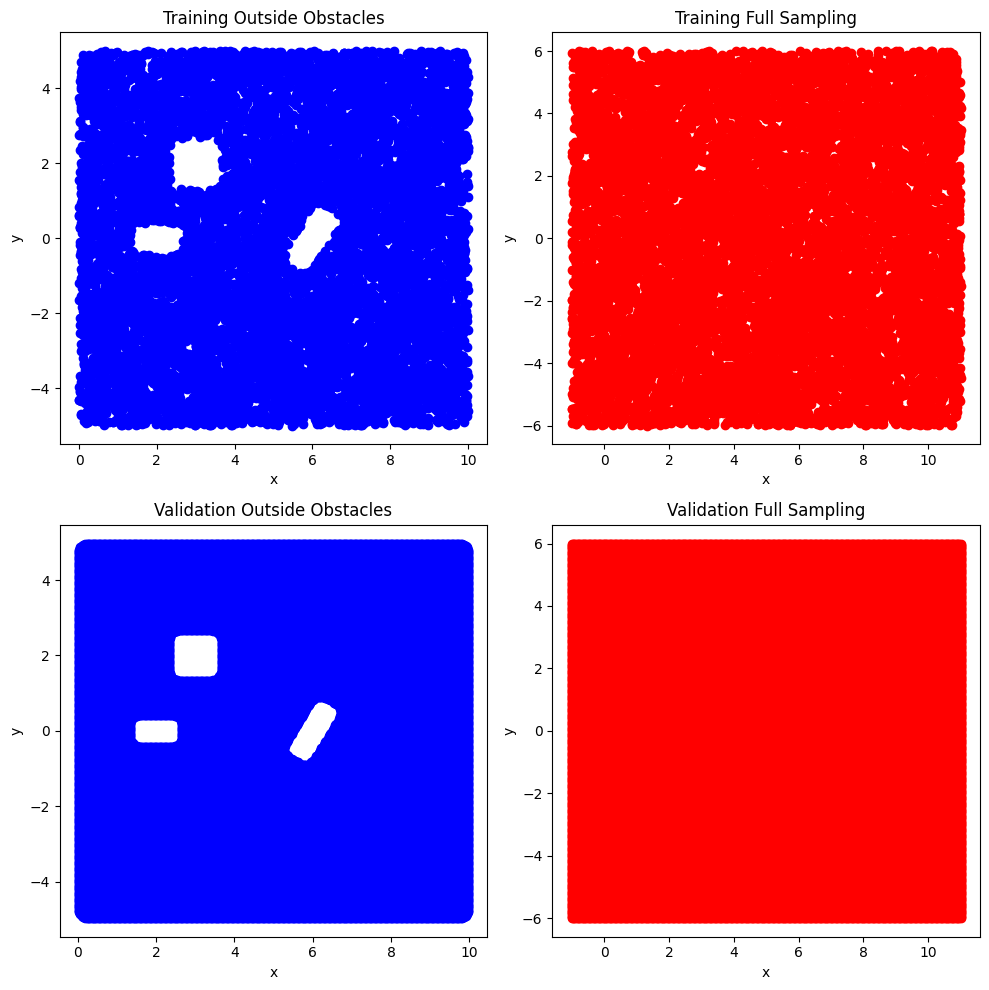

In [16]:
#Sample data and plot
def plot_sampled_data(training_outside, training_full, validation_outside, validation_full):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Plot training data sampled outside obstacles
    axs[0, 0].scatter(training_outside[:, 0], training_outside[:, 1], c='b', label='Training Outside')
    axs[0, 0].set_title('Training Outside Obstacles')
    axs[0, 0].set_xlabel('x')
    axs[0, 0].set_ylabel('y')

    # Plot training data sampled without constraint
    axs[0, 1].scatter(training_full[:, 0], training_full[:, 1], c='r', label='Training Uniform')
    axs[0, 1].set_title('Training Full Sampling')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('y')

    # Plot validation data sampled outside obstacles
    axs[1, 0].scatter(validation_outside[:, 0], validation_outside[:, 1], c='b', label='Validation Outside')
    axs[1, 0].set_title('Validation Outside Obstacles')
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('y')

    # Plot validation data sampled without constraint
    axs[1, 1].scatter(validation_full[:, 0], validation_full[:, 1], c='r', label='Validation Uniform')
    axs[1, 1].set_title('Validation Full Sampling')
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('y')

    plt.tight_layout()
    plt.show()

# Example usage:

# Sample training data for both cases
key = random.PRNGKey(0)
y_train_outside, c_train_outside, gradc_train_outside = sample_training_data(key, sample_outside=True)
y_train_full,  c_train_full, gradc_train_full = sample_training_data(key, sample_outside=False)

# Sample validation data for both cases
y_val_outside, c_val_outside, gradc_val_outside = sample_validation_data(sample_outside=True)
y_val_full, c_val_full, gradc_val_full= sample_validation_data(sample_outside=False)

# Plot the scatter plots
plot_sampled_data(y_train_outside, y_train_full, y_val_outside, y_val_full)

In [ ]:
#Create training datagenerators
training_dataset_outside  = DataGenerator(y_train_outside, np.expand_dims(c_train_outside, axis=1), gradc_train_outside, batch_size = batch_size)
training_dataset_full = DataGenerator(y_train_full, np.expand_dims(c_train_full, axis=1), gradc_train_full, batch_size = batch_size)

In [ ]:
#Initalize models
model_HJ = PI_MLP(layers, lamb_1=0, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)
model_HJ_IS = PI_MLP(layers, lamb_1=0, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)
model_HJ_CBF01 = PI_MLP(layers, lamb_1=lamb_1, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)
model_HJ_CBF02 = PI_MLP(layers, lamb_1=0.2, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)
model_HJ_CBF01_IS = PI_MLP(layers, lamb_1=lamb_1, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)
model_HJ_CBF02_IS = PI_MLP(layers, lamb_1=0.2, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)

100%|██████████| 30000/30000 [01:13<00:00, 410.32it/s, Train Loss=0.0023191473]


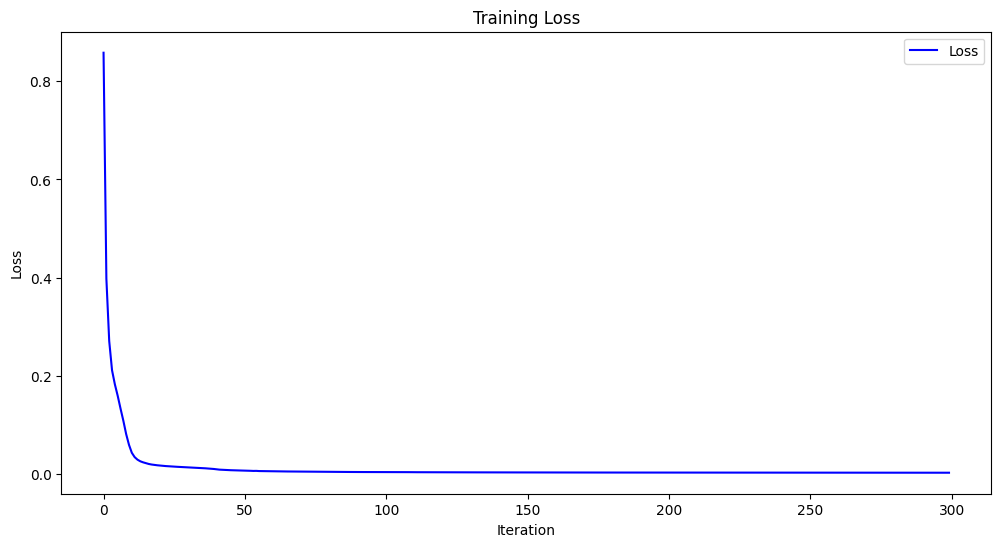

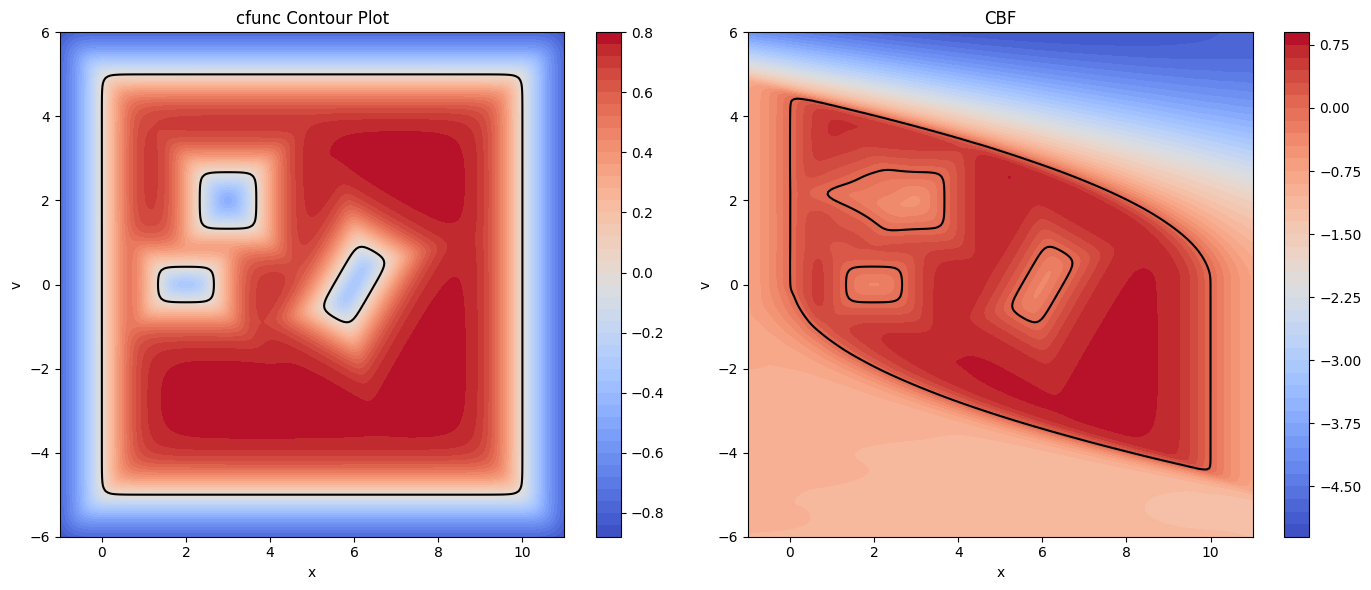

100%|██████████| 30000/30000 [01:12<00:00, 411.82it/s, Train Loss=0.0023335735]


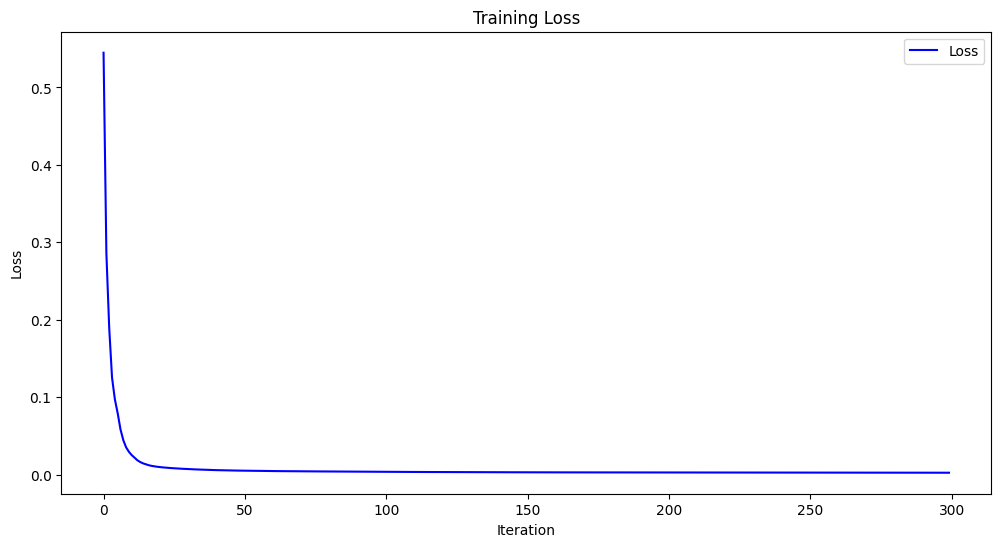

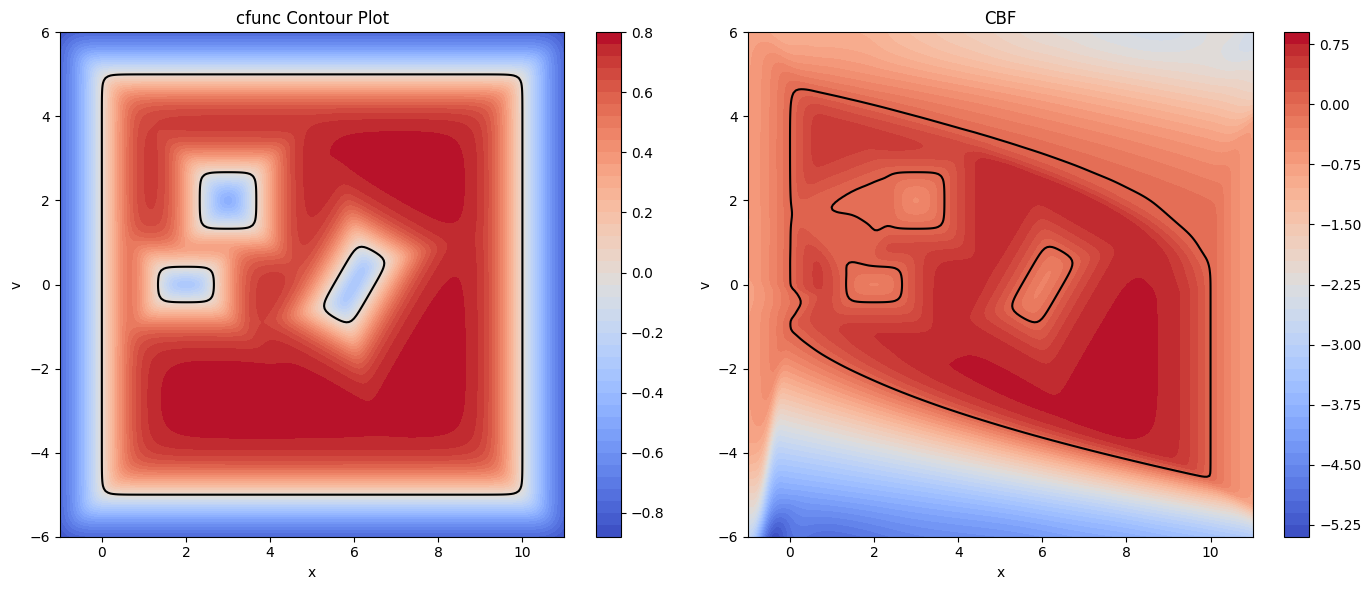

100%|██████████| 30000/30000 [01:11<00:00, 419.54it/s, Train Loss=0.0031151709]


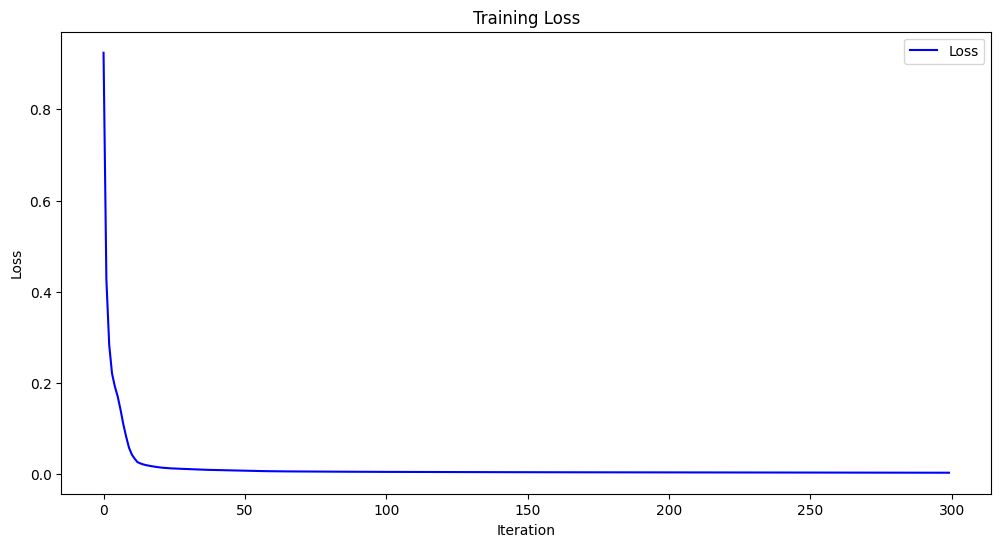

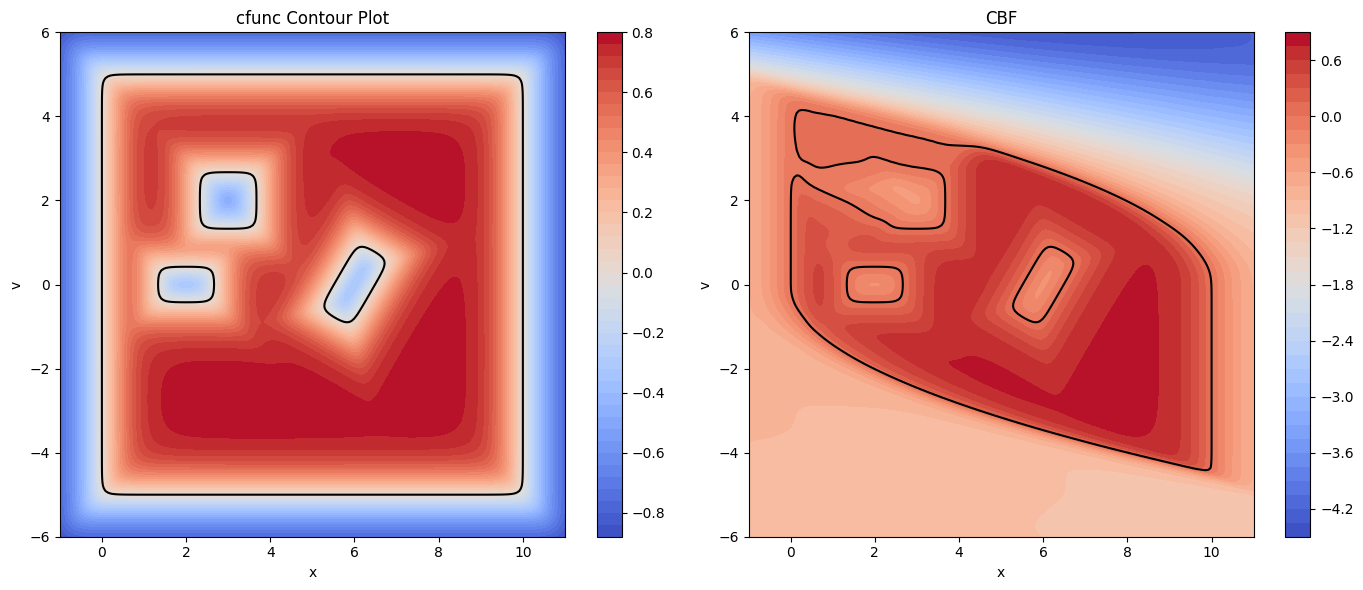

100%|██████████| 30000/30000 [01:11<00:00, 417.66it/s, Train Loss=0.0024797865]


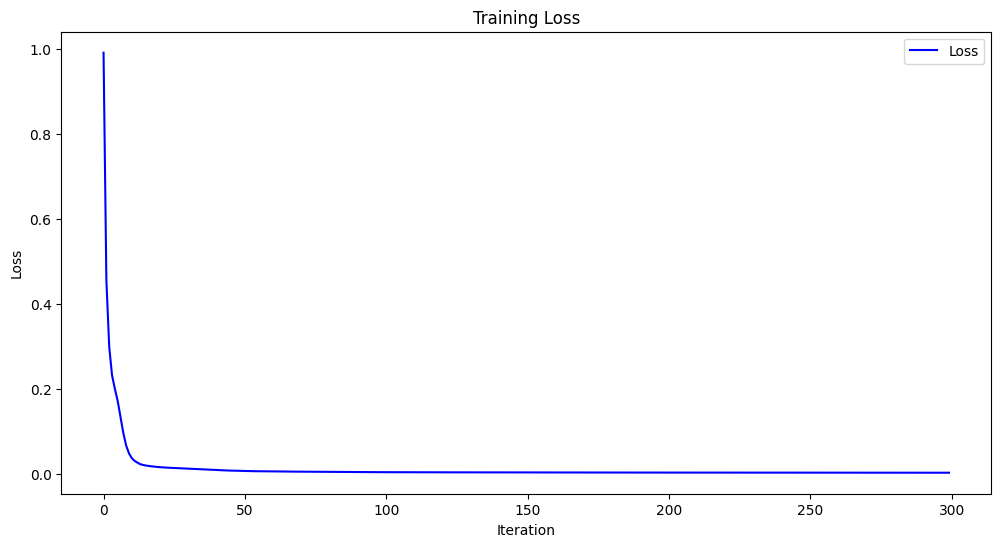

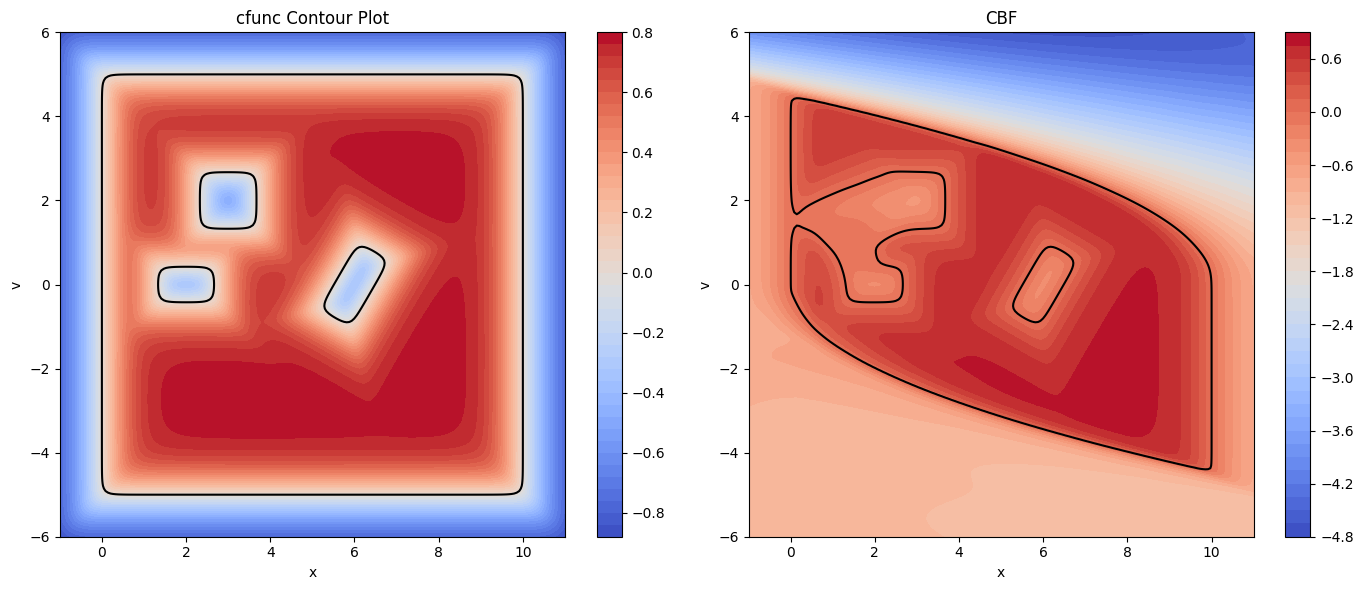

100%|██████████| 30000/30000 [01:11<00:00, 419.70it/s, Train Loss=0.0023602338]


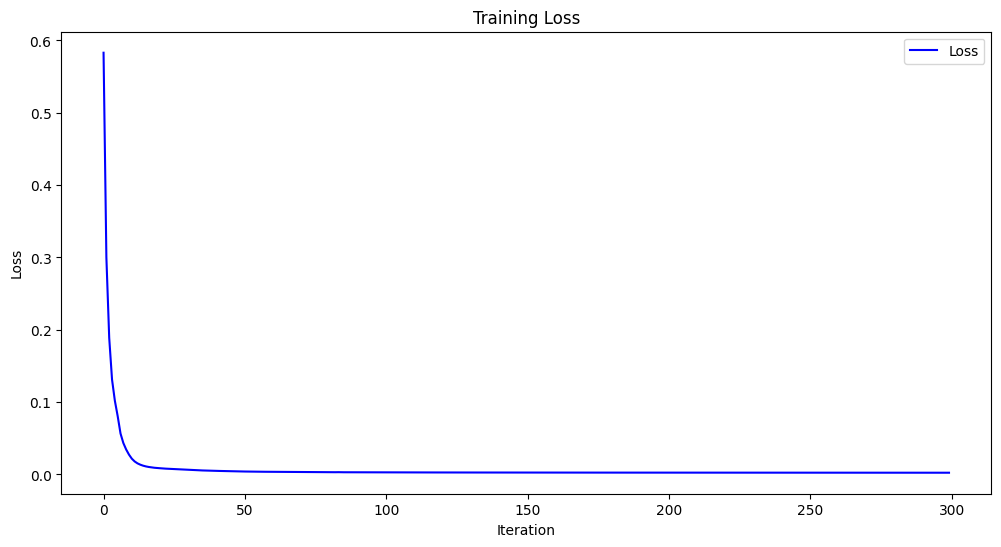

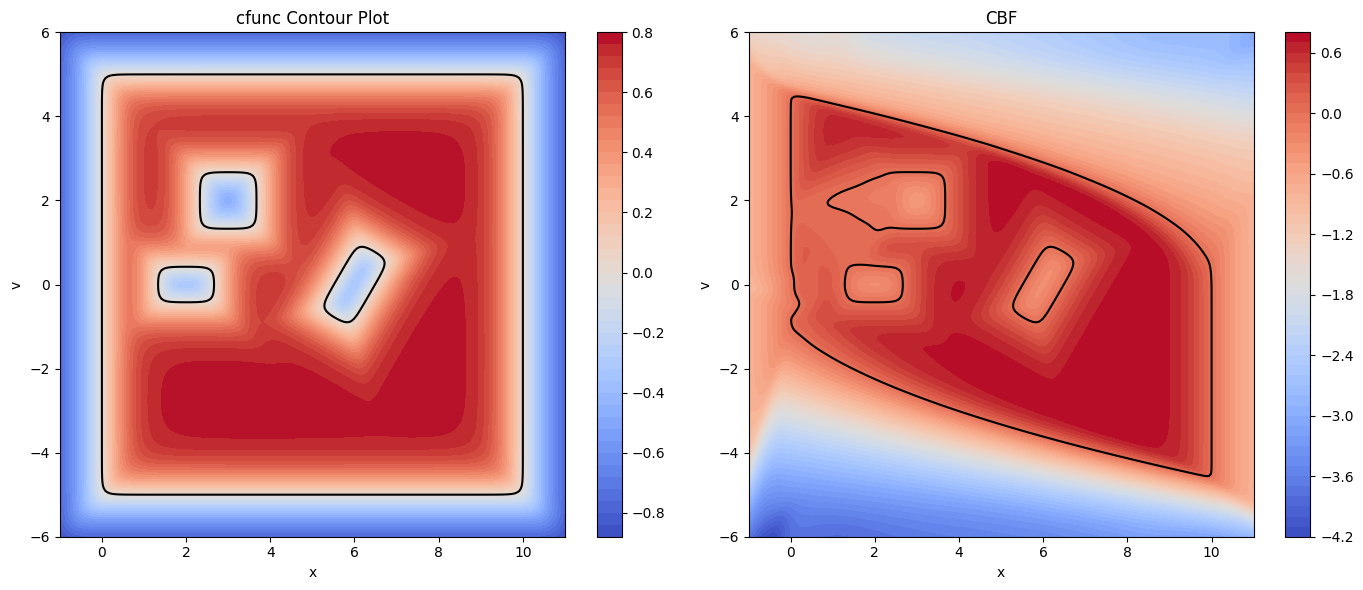

100%|██████████| 30000/30000 [01:11<00:00, 420.79it/s, Train Loss=0.0019036789]


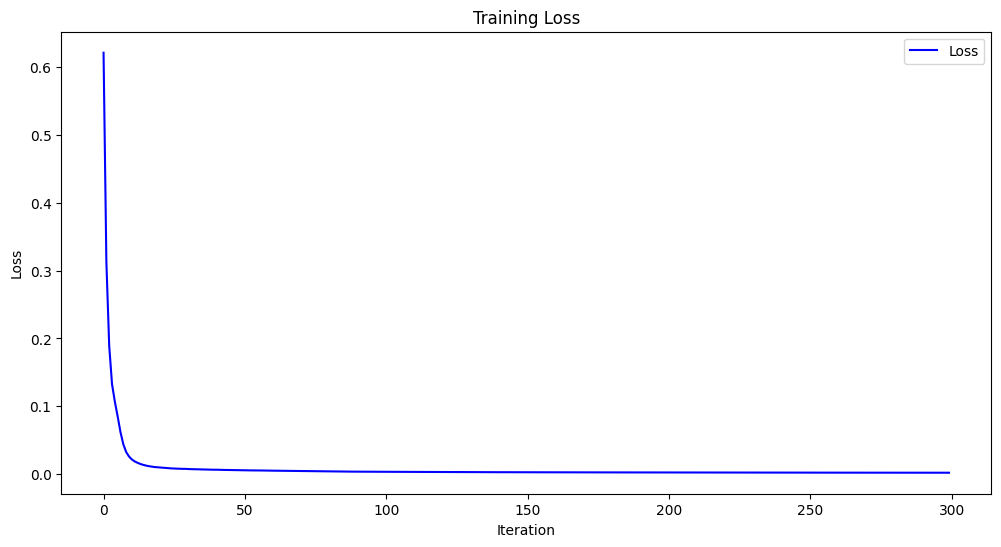

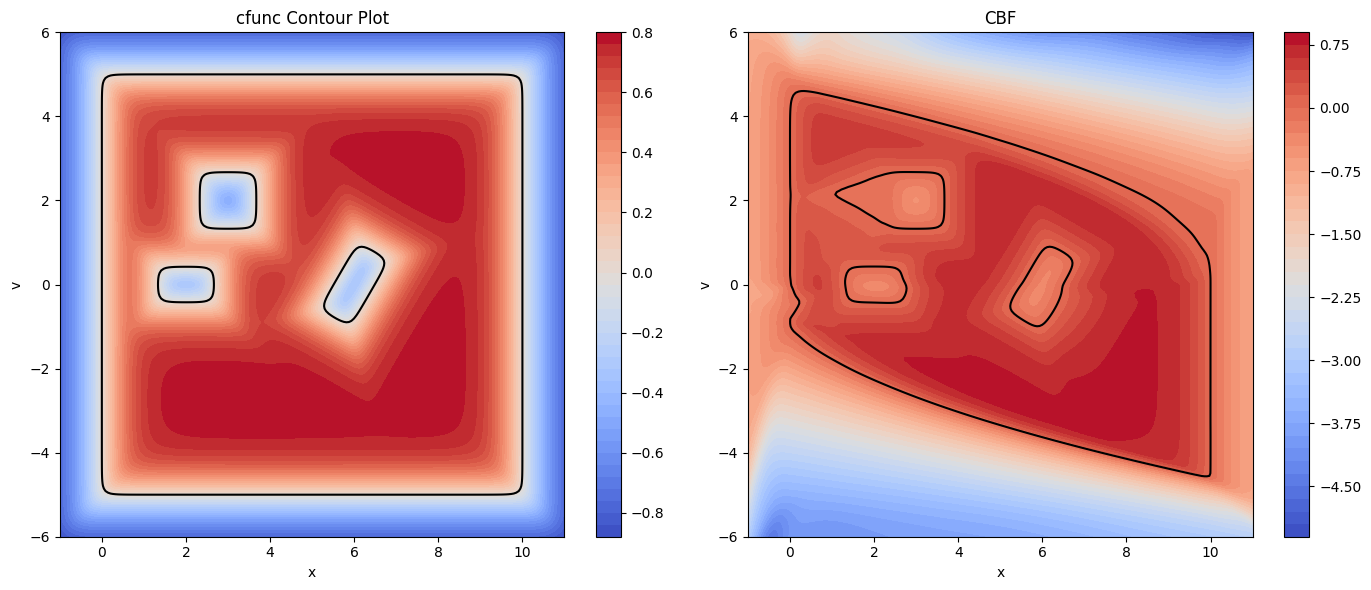

In [ ]:
#Training and visualization
model_HJ.train(training_dataset_full)
model_HJ.plot_losses()
model_HJ.plot_predictions()

model_HJ_IS.train(training_dataset_outside)
model_HJ_IS.plot_losses()
model_HJ_IS.plot_predictions()

model_HJ_CBF01.train(training_dataset_full)
model_HJ_CBF01.plot_losses()
model_HJ_CBF01.plot_predictions()

model_HJ_CBF02.train(training_dataset_full)
model_HJ_CBF02.plot_losses()
model_HJ_CBF02.plot_predictions()

model_HJ_CBF01_IS.train(training_dataset_outside)
model_HJ_CBF01_IS.plot_losses()
model_HJ_CBF01_IS.plot_predictions()

model_HJ_CBF02_IS.train(training_dataset_outside)
model_HJ_CBF02_IS.plot_losses()
model_HJ_CBF02_IS.plot_predictions()

In [ ]:
# CBF model
DI_CBF = PI_MLP(layers, lamb_0=0, lamb_1=1, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)

100%|██████████| 30000/30000 [01:14<00:00, 400.47it/s, Train Loss=0.0]


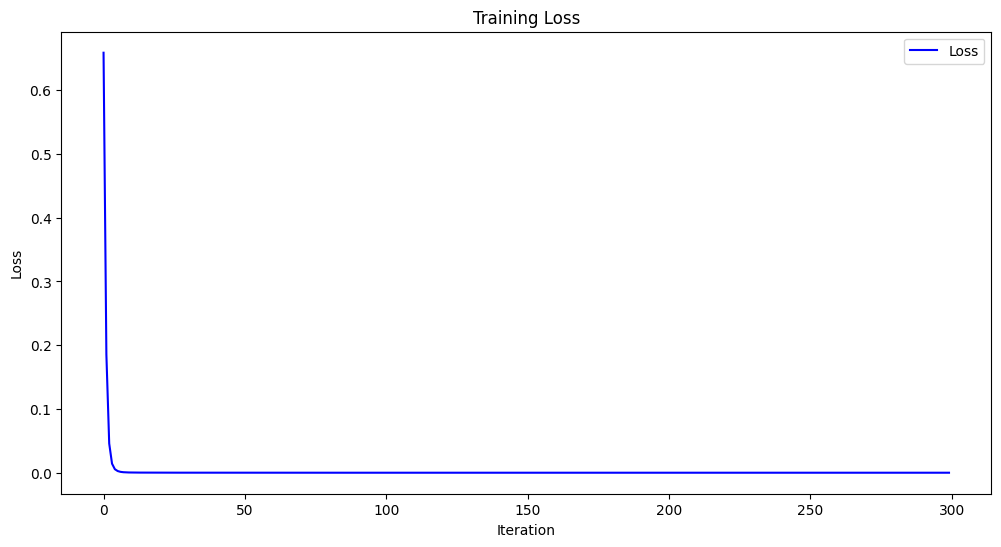

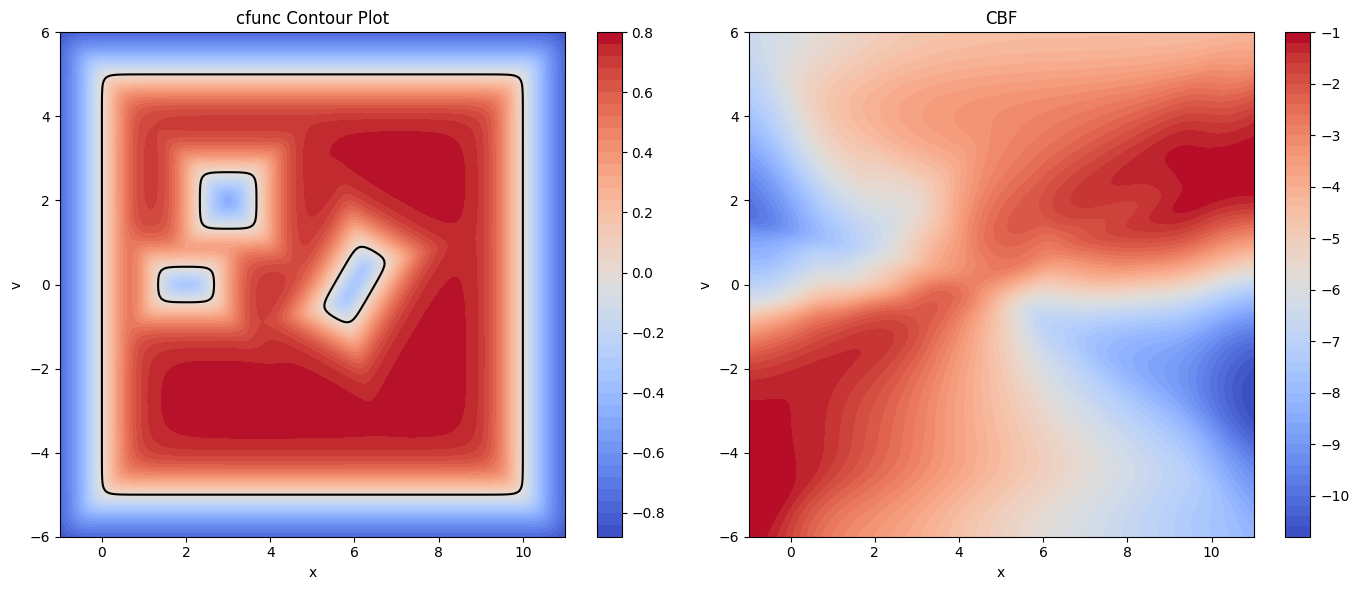

In [ ]:
#Training and visualization
DI_CBF.train(training_dataset_full)
DI_CBF.plot_losses()
DI_CBF.plot_predictions()

In [ ]:
# Validation CBF
print("Validation for DI_CBF")
validation(DI_CBF, y_val_outside, c_val_outside, gradc_val_outside)

Validation for DI_CBF
Average of abs_res_I: 2.001837730407715
Maximum of abs_res_I: 7.028020858764648
Standard deviation of abs_res_I: 1.1459922790527344
Average of safety: 8.057415107032284e-05
Relative volume: 0.0


In [ ]:
# Validation
print("Validation for model_HJ")
validation(model_HJ, y_val_outside, c_val_outside, gradc_val_outside)

print("\nValidation for model_HJ_IS")
validation(model_HJ_IS, y_val_outside, c_val_outside, gradc_val_outside)

print("\nValidation for model_HJ_CBF01")
validation(model_HJ_CBF01, y_val_outside, c_val_outside, gradc_val_outside)

print("\nValidation for model_HJ_CBF02")
validation(model_HJ_CBF02, y_val_outside, c_val_outside, gradc_val_outside)

print("\nValidation for model_HJ_CBF01_IS")
validation(model_HJ_CBF01_IS, y_val_outside, c_val_outside, gradc_val_outside)

print("\nValidation for model_HJ_CBF02_IS")
validation(model_HJ_CBF02_IS, y_val_outside, c_val_outside, gradc_val_outside)

Validation for model_HJ
Average of abs_res_I: 0.026743872091174126
Maximum of abs_res_I: 0.8327165246009827
Standard deviation of abs_res_I: 0.053131572902202606
Average of safety: 0.016084734350442886
Relative volume: 0.5661892294883728

Validation for model_HJ_IS
Average of abs_res_I: 0.022658951580524445
Maximum of abs_res_I: 0.8415050506591797
Standard deviation of abs_res_I: 0.04610013589262962
Average of safety: 0.013898123055696487
Relative volume: 0.6210538148880005

Validation for model_HJ_CBF01
Average of abs_res_I: 0.0304127037525177
Maximum of abs_res_I: 0.8280217051506042
Standard deviation of abs_res_I: 0.06030343100428581
Average of safety: 0.01575152762234211
Relative volume: 0.5448853373527527

Validation for model_HJ_CBF02
Average of abs_res_I: 0.02624422125518322
Maximum of abs_res_I: 0.5008714199066162
Standard deviation of abs_res_I: 0.05013292282819748
Average of safety: 0.014522903598845005
Relative volume: 0.5470464825630188

Validation for model_HJ_CBF01_IS
Ave

In [ ]:
with open('DI_HJ.pkl', 'wb') as f:
    dill.dump(model_HJ, f)
with open('DI_HJ_IS.pkl', 'wb') as f:
    dill.dump(model_HJ_IS, f)
with open('DI_HJ_CBF01.pkl', 'wb') as f:
    dill.dump(model_HJ_CBF01, f)
with open('DI_HJ_CBF02.pkl', 'wb') as f:
    dill.dump(model_HJ_CBF02, f)
with open('DI_HJ_CBF01_IS.pkl', 'wb') as f:
    dill.dump(model_HJ_CBF01_IS, f)
with open('DI_HJ_CBF02_IS.pkl', 'wb') as f:
    dill.dump(model_HJ_CBF02_IS, f)

In [ ]:
with open('DI_CBF.pkl', 'wb') as f:
    dill.dump(DI_CBF, f)

##Safety Filter

In [17]:
class PIDController:
    def __init__(self, kpx, kix, kdx, kpv, kiv, kdv, dt, filter = None, alpha = .05):
        #Controller parameters
        # self.x0 = x0
        # self.v0 = v0
        # self.x_f = x_f
        # self.v_f = v_f
        self.kpx = kpx  # Proportional gain x
        self.kix = kix  # Integral gain x
        self.kdx = kdx  # Derivative gain x
        self.kpv = kpv  # Proportional gain v
        self.kiv = kiv  # Integral gain v
        self.kdv = kdv  # Derivative gain v
        self.dt = dt  # Time step
        self.alpha = alpha

        self.filter = filter
        if self.filter != None:
            self.filter_params = self.filter.get_params(self.filter.opt_state)

        # Initialize integral error and previous error
        self.integral_error_x = 0
        self.integral_error_v = 0
        self.prev_error_x = 0
        self.prev_error_v = 0

    def update_alpha (self, alpha_new):
        self.alpha = alpha_new

    def safety_correction(self, x, v, u):
        # Define decision variable
        if self.filter == None:
            # Clamp control input to [-1, 1]
            u = max(min(u, 1), -1)

            return u
        else:
            #Evaluate the output for an enviornment and state
            delta = self.filter.net_diff(self.filter_params, x, v)

            ddeltadx = grad(self.filter.net_diff, argnums=1)(self.filter_params, x, v)
            ddeltadv = grad(self.filter.net_diff, argnums=2)(self.filter_params, x, v)

            dcdx = grad(smooth_cfunc, argnums=0)(x, v, rectangles, circles)
            dcdv = grad(smooth_cfunc, argnums=1)(x, v, rectangles, circles)
            c = smooth_cfunc(x, v, rectangles, circles)

            #compute h and gradh
            h = c - delta
            #print(h)
            dhdx = dcdx - ddeltadx
            dhdv = dcdv - ddeltadv

            a = self.alpha
            signh = np.sign(h)
            max_it = 10
            it = 0

            u_var = cp.Variable()

            while u_var.value == None and it < max_it:
                it += 1
                a = a * 1.5 **(signh * it)
                #Quadratic program
                u_var = cp.Variable()
                u_ref = u

                # Objective
                objective = cp.Minimize((u_var - u_ref)**2)

                # Define constraints with additional slack bounded above by epsilon
                constraints = [dhdx * v + dhdv * u_var + a * h >= 0,
                                u_var <= 1,
                                u_var >= -1]

                # Formulate the optimization problem
                problem = cp.Problem(objective, constraints)

                # Solve the problem
                problem.solve()
            return u_var.value.item() if problem.status == 'optimal' else None

    def control(self, x, v, xf, vf):
        # Calculate error terms
        error_x = x - xf
        error_v = v - vf
        derivative_error_x = (error_x - self.prev_error_x) / self.dt
        derivative_error_v = (error_v - self.prev_error_v) / self.dt
        self.integral_error_x += error_x * self.dt
        self.integral_error_v += error_v * self.dt

        # Calculate reference control input
        u = (self.kpx * error_x + self.kix * self.integral_error_x + self.kdx * derivative_error_x +
             self.kpv * error_v + self.kiv * self.integral_error_v + self.kdv * derivative_error_v)

        u = self.safety_correction(x, v, u)

        # Update previous error
        self.prev_error_x = error_x
        self.prev_error_v = error_v

        return u

    def update_state(self, x, v, xf, vf):
        u_t = self.control(x, v, xf, vf)

        v_next = v + u_t * self.dt
        x_next = x + v * self.dt + 0.5 * u_t * self.dt**2
        return x_next, v_next

    def calculate_trajectory(self, x0, v0, xf, vf, T, epsilon=0.01):
        x_states  = [x0]
        v_states = [v0]
        x = x0
        v = v0
        for _ in range(T):
            x, v = self.update_state(x, v, xf, vf)
            x_states.append(x)
            v_states.append(v)

            # Check for convergence
            if abs(x - xf) < epsilon and abs(v - vf) < epsilon:
                break

        return x_states, v_states

    #Plot the heatmap of the CBF first and its zero level set. Then Plot the trajectory in between with a blue dashed line and blue start points. Plot the box with a black dashed line
    def plot_trajectory(self, x_trajectories, v_trajectories, initial_positions, initial_velocities, final_positions, final_velocities, colors=None, save_name=None): #can be multiple trajectories
        plt.figure(figsize=(7, 6))
        plt.xlabel('x', fontsize = 14)
        plt.ylabel('v', fontsize = 14)
        #plt.title('State Trajectory of the 1D Double Integrator System', fontsize=18)
        plt.xlim(-1, 11)
        plt.ylim(-6, 6)

        #Plot cbf and 0-Level Set
        if self.filter != None:
            #x_coords, y_coords, h used to be (1,100^2)
            P = 200
            x_coords = np.linspace(-1, 11, P)
            v_coords = np.linspace(-6, 6, P)
            x_mesh, v_mesh = np.meshgrid(x_coords, v_coords)
            states_x = x_mesh.flatten()[:, None]
            states_v = v_mesh.flatten()[:, None]

            c = vmap(smooth_cfunc, (0, 0, None, None))(np.squeeze(states_x), np.squeeze(states_v), rectangles, circles)
            delta = vmap(self.filter.net_diff, (None, 0, 0))(self.filter.get_params(self.filter.opt_state), states_x, states_v)

            h = c - delta

            plt.scatter(states_x, states_v, c=h, cmap='coolwarm')
            plt.colorbar()
            contour = plt.contour(states_x.reshape(P, P), states_v.reshape(P, P), h.reshape(P, P), levels=[0], colors='black') #label='Zero Level Set of Learned CBF
            #contour.collections[0].set_label('\u2014 Zero Level Set of Learned CBF')

        #Plot trajectory and start-end points
        num_trajectories = len(x_trajectories)

        for i in range(num_trajectories):
            if colors is None:
                plt.plot(x_trajectories[i], v_trajectories[i], color='blue', linestyle='--')
            else:
                plt.plot(x_trajectories[i], v_trajectories[i], color=colors[i], linestyle='--')

            plt.plot(initial_positions[i], initial_velocities[i], 'bo', markersize=12) #label='Start Point ($x_0$, $v_0$)'
            plt.plot(final_positions[i], final_velocities[i], 'b^', markersize=12) # label='Target Point ($x_f$, $v_f$)'

        #Plot box
        # box_x = [0, 10, 10, 0, 0]
        # box_y = [-5, -5, 5, 5, -5]
        # plt.plot(box_x, box_y, color='purple', linestyle='-')

        #Add obstacles on top
        if self.filter != None:
            for rectangle in rectangles:
                theta, width, height, xc, yc = rectangle
                x_corner = xc - .5 * width * np.cos(theta) + .5 * height * np.sin(theta)
                y_corner = yc - .5 * height * np.cos(theta) - .5 * width * np.sin(theta)

                degrees = theta * 180 / np.pi

                rect = Rectangle((x_corner, y_corner), width, height, angle = degrees, rotation_point = 'xy', color='black', alpha=0.8, fill=True)
                plt.gca().add_patch(rect)

            for circ in circles:
                radius, x_center, y_center = circ

                circle = Circle((x_center, y_center), radius, color='black', alpha=0.8, fill=True)
                plt.gca().add_patch(circle)

        #plt.legend(loc='upper right', fontsize=12)

        # Increase tick label font size
        plt.xticks(fontsize=14)  # Adjust the font size as needed
        plt.yticks(fontsize=14)  # Adjust the font size as needed

        plt.tight_layout()

        if save_name is not None:
            plt.savefig(save_name, bbox_inches='tight')

        plt.show()

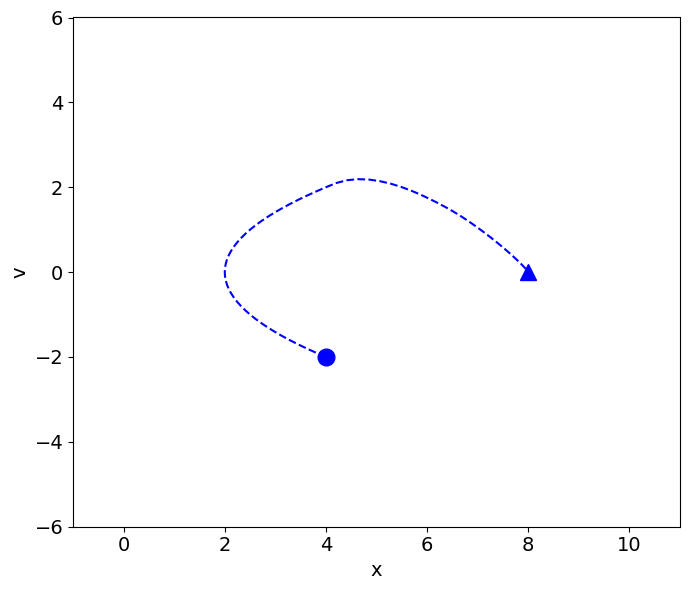

In [18]:
#No obstacle case
# Reference Controller Parameters
x0 = 4.0  # Initial position
v0 = -2.0 # Initial velocity (-2.0)
xf = 8.0  # Desired final position
vf = 0.0  # Desired final velocity
kpx = -1.2  # Proportional gain x
kix = 0.0  # Integral gain x
kdx = 0.1  # Derivative gain x
kpv = -2.0  # Proportional gain v
kiv = 0.0  # Integral gain v
kdv = 0.1  # Derivative gain v
dt = 0.1  # Time step
T = 120  # Number of time steps


# Initialize PID controller
pid_controller = PIDController(kpx, kix, kdx, kpv, kiv, kdv, dt)

# Calculate trajectory
x_states, v_states = pid_controller.calculate_trajectory(x0, v0, xf, vf, T)

# Plot trajectory
pid_controller.plot_trajectory([x_states], [v_states], [x0], [v0], [xf], [vf])

In [28]:
#Load Flter
with open('DI_HJ_CBF02_IS.pkl', 'rb') as f:
    CBF_model = dill.load(f)

In [26]:
filter = CBF_model #Select CBF model to use as a filter

# Initialize PID controller
pid_controller = PIDController(kpx, kix, kdx, kpv, kiv, kdv, dt, filter = filter, alpha = .5)


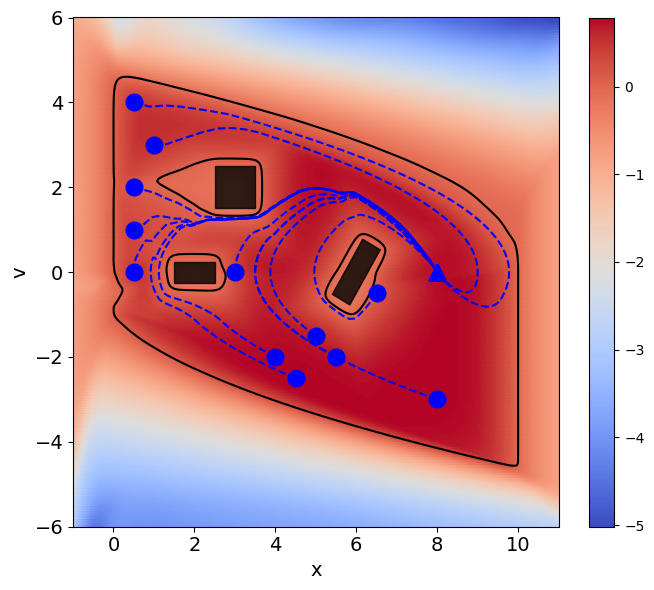

In [29]:
# x0 = [6.5, 4.0, 4.5, 5.0, 5.5, 3.0, 3.5, 8.0, 1.0, 0.5, 0.5, 0.5, 0.5] # Initial position
# v0 = [-0.5, -2.0, -2.5, -1.5, -2.0, 0.0, -1.0, -3.0, 3.0, 4.0, 2.0, 1.0, 0.0] # Initial velocity (-2.0)
# xf = [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]  # Desired final position
# vf = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] # Desired final velocity

x0 = [6.5, 4.0, 4.5, 5.0, 5.5, 3.0, 8.0, 1.0, 0.5, 0.5, 0.5, 0.5] # Initial position
v0 = [-0.5, -2.0, -2.5, -1.5, -2.0, 0.0, -3.0, 3.0, 4.0, 2.0, 1.0, 0.0] # Initial velocity (-2.0)
xf = [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0]  # Desired final position
vf = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] # Desired final velocity


# x0 = [6.5] # Initial position
# v0 = [-0.5] # Initial velocity (-2.0)
# xf = [8.0]  # Desired final position
# vf = [0.0] # Desired final velocity


dt = .1 # Time step
T = 200 # Number of time steps

filter = CBF_model #Select CBF model to use as a filter

# Initialize PID controller
pid_controller = PIDController(kpx, kix, kdx, kpv, kiv, kdv, dt, filter = filter, alpha = .5)

x_trajectories = []
v_trajectories = []
# Calculate trajectories
for i in range(len(x0)):
    x_states, v_states = pid_controller.calculate_trajectory(x0[i], v0[i], xf[i], vf[i], T)
    x_trajectories.append(x_states)
    v_trajectories.append(v_states)

# Plot trajectories
pid_controller.plot_trajectory(x_trajectories, v_trajectories, x0, v0, xf, vf)


In [30]:
print(x_trajectories)
print(v_trajectories)

[[6.5, 6.446196170608793, 6.384463837344543, 6.314130347797854, 6.234482244304756, 6.145648386364595, 6.047548374196321, 5.941169490450643, 5.831181169536482, 5.723101923442917, 5.620263627789527, 5.523775024929188, 5.433749021205519, 5.350001951298374, 5.272396407263229, 5.201146279134033, 5.137574612845471, 5.083384268992334, 5.039193925139196, 5.005003581286059, 4.980813237432921, 4.966622893579784, 4.962432549726646, 4.9682422058735085, 4.984051862020371, 5.0098615181672335, 5.045671174314096, 5.0914808304609585, 5.147290486607821, 5.2131001427546835, 5.288909798901546, 5.3747194550484085, 5.470529111195271, 5.576338767342134, 5.692056476386134, 5.815536717109776, 5.943959920698551, 6.076998358354029, 6.211462904266185, 6.3427838991636944, 6.469529786863706, 6.59088543860079, 6.706308952738562, 6.815455279770187, 6.918136886495667, 7.014293286516626, 7.1039654948586, 7.187274432717844, 7.264402722122514, 7.3355794120080695, 7.401067236056271, 7.461152051392379, 7.516134150262285, 7

In [31]:
# Create a directory to save images
output_dir = "trajectory_images_new"
os.makedirs(output_dir, exist_ok=True)

# Maximum length of the trajectories
length = max(len(x) for x in x_trajectories)

# Pad each trajectory with the last state value
padded_x_trajectories = []
for x_s in x_trajectories:
    padded_x_s = x_s + [x_s[-1]] * (length - len(x_s))
    padded_x_trajectories.append(padded_x_s)

padded_v_trajectories = []
for v_s in v_trajectories:
    padded_v_s = v_s + [v_s[-1]] * (length - len(v_s))
    padded_v_trajectories.append(padded_v_s)

# Generate images for each time step
for t in range(length):
    # Truncate trajectories at time step t
    truncated_x_trajectories = [x_s[:t+1] for x_s in padded_x_trajectories]
    truncated_v_trajectories = [v_s[:t+1] for v_s in padded_v_trajectories]

    # Plot truncated trajectories
    # plt.close()  # Close any existing plots
    pid_controller.plot_trajectory(truncated_x_trajectories, truncated_v_trajectories, x0, v0, xf, vf, save_name=f"{output_dir}/trajectory_frame_{t:03d}.png")

    # Save the plot as an image
    # plt.savefig(f"{output_dir}/trajectory_frame_{t:03d}.png", bbox_inches='tight')
    # plt.clf()  # Clear the current figure for the next plot

# Create a video from the saved images
video_filename = 'trajectory_video.avi'
images = [f"{output_dir}/trajectory_frame_{t:03d}.png" for t in range(length)]

# Get dimensions for the video
frame = cv2.imread(images[0])
height, width, layers = frame.shape
video = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'XVID'), 24, (width, height))

for image in images:
    video.write(cv2.imread(image))

video.release()  # Release the video writer
print(f"Video saved as {video_filename}")

Output hidden; open in https://colab.research.google.com to view.